# Introduction #

We saw in the first lesson how to build an image classifier by attaching an untrained head of dense layers to a pretrained convolutional base. Since the pretrained base had already learned how to extract visual features, we could train an accurate image classifier with relatively little data.

In this lesson, we'll use the understanding we've gained of the layers in the convolutional base to improve this method even more. The key is in the hierarchy of visual features we learned about in the previous lesson.

# Using the Hierarchy of Features #

Let's review what we know about the feature extraction in the convolutional base.

The base is a sequence of layers that each perform a step in the extraction process. By the time the data has reached the classifier, it has undergone the extraction process many times. Simple features in the shallow layers combine and recombine to form the complex features in the deepest layers.

<!--TODO: feature extraction-->

Because the network learns which features to extract to solve its classification problem, the features produced by the deepest layers will often closely resemble the training data.

The features produced by shallow layers, however, tend to be more generic and will generalize much better to a range of datasets.

For instance, suppose we train a convnet on images of dogs. The shallow layers will tend to produce features like lines and textures and contrasts, features useful on almost every problem. The deepest layers will tend to produce features resembling fur and eyes and snouts. It is unlikely these layers would be useful when classifying cars or flowers.

<!--TODO: optimal features-->

# Fine Tuning #

What this means is that when we are using a pretrained base as a feature extractor, it may be best to retrain some of its layers, starting with those closest to the output.

This technique is called **fine tuning**. It ensures that the layers most important for the classification have a chance to adapt to the new dataset.

In Lesson 1, we created a classifier by using a pretrained base with an untrained head of dense layers. During training, *only* the weights of the dense layers were updated. The the layers in the base were not trained; their weights we kept **frozen**.

To fine tune the model, we continue the training by **unfreezing** the layers in the base one-by-one until the model begins to **overfit**.

<!--TODO: overfitting-->

At that point, we know that unfreezing additional layers will be unlikely to improve the accuracy of the model on unseen data.

# Example - Training with Fine Tuning #

Let's work through an example to see how it goes. As before, let's assume we've already loaded a dataset with a training split `ds_train` and a validation split `ds_valid`.

In [1]:
#$HIDE$
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

import visiontools as vt
from visiontools import StanfordCars
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = '/home/jovyan/work/kaggle/datasets'

(ds_train, ds_valid), ds_info = tfds.load('stanford_cars/simple',
                                          split=['train', 'test'],
                                          shuffle_files=True,
                                          with_info=True,
                                          data_dir=DATA_DIR)

BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE
SIZE = [192, 192]
preprocess = vt.make_preprocessor(size=SIZE)

ds_train_ = (ds_train.map(preprocess)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTO))

ds_valid_ = (ds_valid.map(preprocess)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTO))

## Step 1 - Define Model ##

Now create a model just like you did in the first lesson, with a pretrained base and several dense layers as a head to act as the classifier.

In [2]:
from tensorflow.keras import Sequential
import tensorflow.keras.layers as layers

from tensorflow.keras.applications import VGG16

pretrained_base = VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=[192, 192, 3])
pretrained_base.trainable = False

model = Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

We're going to set up the training loop a little bit differently than before.

In [3]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=160,
    decay_rate=0.80,
    staircase=True,
)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

# Number of epochs per round of training
EPOCHS = 5

## Step 2 - Train Classifier Head ##

Now, keeping all the layers in the base frozen, train the model until the validation loss no longer improves.

In [4]:
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(ds_train_,
                    validation_data=ds_valid_,
                    epochs=EPOCHS)

Epoch 1/5
160/160 [==============================] - 47s 295ms/step - loss: 0.5527 - accuracy: 0.7266 - val_loss: 0.4684 - val_accuracy: 0.8452
Epoch 2/5
160/160 [==============================] - 39s 243ms/step - loss: 0.4297 - accuracy: 0.8634 - val_loss: 0.4221 - val_accuracy: 0.8860
Epoch 3/5
160/160 [==============================] - 38s 236ms/step - loss: 0.2581 - accuracy: 0.9103 - val_loss: 0.2460 - val_accuracy: 0.8998
Epoch 4/5
160/160 [==============================] - 38s 238ms/step - loss: 0.1794 - accuracy: 0.9414 - val_loss: 0.2295 - val_accuracy: 0.9030
Epoch 5/5
160/160 [==============================] - 38s 239ms/step - loss: 0.1512 - accuracy: 0.9549 - val_loss: 0.2367 - val_accuracy: 0.9016


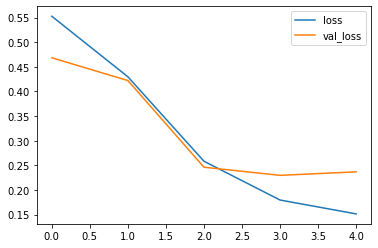

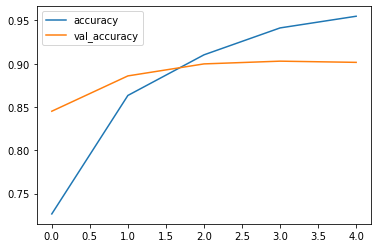

In [5]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

## Step 3 - Fine Tune the Base ##

Let's look at the layers in the base. We'll print out names and indices.

In [6]:
for idx, layer in enumerate(pretrained_base.layers):
    print(idx, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


Let's tune the convolutional layers in block 5. This gives us indices, from the end backwards, `[17, 16, 15]`.

Iterate over top layers, tuning one by one. Since we've set the number of epochs per training round to `EPOCHS=5`, this will give us 5+3*5 = 20 epochs total.

In [7]:
for r, idx in enumerate([17, 16, 15]):
    print("Unfreezing layer at index {}.".format(idx))
    pretrained_base.layers[idx].trainable = True

    # Recompile model after unfreezing a layer.
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )
    # Define epochs
    INIT, = history.epoch[-1] + 1, # start after last iteration's end
    TOTAL = history.epoch[-1] + 1 + EPOCHS
    # Retrain with layer at idx unfrozen.
    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        initial_epoch=INIT,
        epochs=TOTAL,
    )
    # Concatenate this round's history to previous history
    history_frame = pd.concat([history_frame, pd.DataFrame(history.history)])

Unfreezing layer at index 17.
Epoch 6/10
160/160 [==============================] - 38s 237ms/step - loss: 0.1325 - accuracy: 0.9625 - val_loss: 0.2213 - val_accuracy: 0.9060
Epoch 7/10
160/160 [==============================] - 38s 236ms/step - loss: 0.1200 - accuracy: 0.9676 - val_loss: 0.2137 - val_accuracy: 0.9101
Epoch 8/10
160/160 [==============================] - 38s 237ms/step - loss: 0.1108 - accuracy: 0.9715 - val_loss: 0.2113 - val_accuracy: 0.9115
Epoch 9/10
160/160 [==============================] - 38s 239ms/step - loss: 0.1040 - accuracy: 0.9744 - val_loss: 0.2099 - val_accuracy: 0.9131
Epoch 10/10
160/160 [==============================] - 38s 239ms/step - loss: 0.0991 - accuracy: 0.9756 - val_loss: 0.2089 - val_accuracy: 0.9127
Unfreezing layer at index 16.
Epoch 11/15
160/160 [==============================] - 39s 242ms/step - loss: 0.0955 - accuracy: 0.9771 - val_loss: 0.2082 - val_accuracy: 0.9133
Epoch 12/15
160/160 [==============================] - 39s 242ms/ste

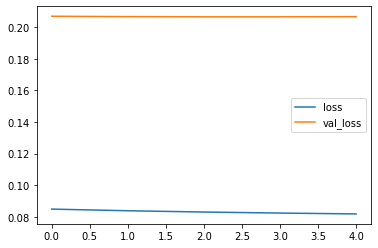

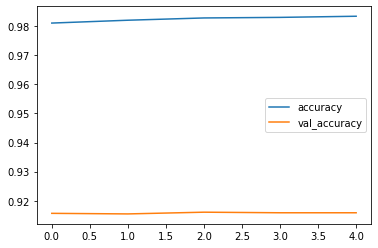

In [8]:
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

# Conclusion #

<!--TODO: tut6 conclusion-->